# Analyze Urban Heat Using Kriging

> * 🔬 Data Science
* 📈 Statistics & Graphing
* 🖥️ Requires ArcPy
* 👟 Ready To Run!

## Introduction

The _urban heat island effect_ is the tendency for city centers to have significantly higher temperatures than surrounding rural areas. This effect is largely due to infrastructure and buildings in city centers that trap heat inside and prevent it from dissipating into surrounding areas. Unfortunately, this means that the places with the largest local populations often experience the highest temperatures. 

To address health issues related to urban heat, you will interpolate temperature measurements taken on August 8, 2016 at 8:00PM in Madison, Wisconsin.  

You will first interpolate the temperature measurements using [*Empirical Bayesian Kriging*](http://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/what-is-empirical-bayesian-kriging-.htm) (EBK). You will then use [*EBK Regression Prediction*](http://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/what-is-ebk-regression-prediction-.htm) in order to incorporate the locations of impervious to water and compare the accuracy of each interpolation. 

To complete the notebook, you will use your interpolation results to identify areas with both high temperatures and a high density of residents over the age of 65, who are at highest risk for heat-related illnesses.

<h1>Table of Contents<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item"><li><span><a href="#Analyze-Urban-Heat-Using-Kriging" data-toc-modified-id="Analyze-Urban-Heat-Using-Kriging-1">Analyze Urban Heat Using Kriging</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Getting-set-up" data-toc-modified-id="Getting-set-up-1.2">Getting set up</a></span></li><li><span><a href="#Exploring-the-temperature-values" data-toc-modified-id="Exploring-the-temperature-values-1.3">Exploring the temperature values</a></span><ul class="toc-item"><li><span><a href="#Plot-observation-locations-on-a-map" data-toc-modified-id="Plot-observation-locations-on-a-map-1.3.1">Plot observation locations on a map</a></span></li><li><span><a href="#Histogram-of-temperature-measurements" data-toc-modified-id="Histogram-of-temperature-measurements-1.3.2">Histogram of temperature measurements</a></span></li></ul></li><li><span><a href="#Interpolate-the-temperature-measurements-using-Empirical-Bayesian-Kriging" data-toc-modified-id="Interpolate-the-temperature-measurements-using-Empirical-Bayesian-Kriging-1.4">Interpolate the temperature measurements using Empirical Bayesian Kriging</a></span><ul class="toc-item"><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-1.4.1">Cross validation</a></span></li></ul></li><li><span><a href="#Incorporate-impervious-surfaces-in-order-to-improve-the-interpolation" data-toc-modified-id="Incorporate-impervious-surfaces-in-order-to-improve-the-interpolation-1.5">Incorporate impervious surfaces in order to improve the interpolation</a></span><ul class="toc-item"><li><span><a href="#Visualize-the-impervious-raster-surface" data-toc-modified-id="Visualize-the-impervious-raster-surface-1.5.1">Visualize the impervious raster surface</a></span></li><li><span><a href="#Verify-that-impervious-surfaces-are-related-to-temperature" data-toc-modified-id="Verify-that-impervious-surfaces-are-related-to-temperature-1.5.2">Verify that impervious surfaces are related to temperature</a></span></li></ul></li><li><span><a href="#Perform-EBK-Regression-Prediction-on-the-temperature-measurements-using-impervious-percent-as-an-explanatory-variable" data-toc-modified-id="Perform-EBK-Regression-Prediction-on-the-temperature-measurements-using-impervious-percent-as-an-explanatory-variable-1.6">Perform EBK Regression Prediction on the temperature measurements using impervious percent as an explanatory variable</a></span><ul class="toc-item"><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-1.6.1">Cross validation</a></span></li><li><span><a href="#Model-evaluation-charts" data-toc-modified-id="Model-evaluation-charts-1.6.2">Model evaluation charts</a></span></li></ul></li><li><span><a href="#Locate-blocks-groups-with-high-risk-of-heat-illnesses" data-toc-modified-id="Locate-blocks-groups-with-high-risk-of-heat-illnesses-1.7">Locate block groups with high risk of heat illnesses</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.8">Conclusion</a></span></li></ul></li></ul></div>

## Getting set up

First, let's import all the necessary libraries we'll need to run this notebook.

In [117]:
import os
import shutil
import zipfile
import arcgis
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import SpatialDataFrame
import pandas as pd
import arcpy

import matplotlib.pyplot as plt
%matplotlib inline

This notebook will be using the `Analyze_Urban_Heat_Using_Kriging.gdb.zip` geodatabase located in `/arcgis/samplesdata/`. Run the below cell to copy that geodatabase to your working directory of `/arcgis/home/` so you can modify it.

In [27]:
arcgis_dir = os.path.abspath(os.path.join(os.sep, 'arcgis'))
home_dir = os.path.join(arcgis_dir, 'home')
samples_dir = os.path.join(arcgis_dir, 'samplesdata')

print(f"root dir: {arcgis_dir}")
print(f"home dir: {home_dir}")
print(f"samples dir: {samples_dir}")

root dir: /arcgis
home dir: /arcgis/home
samples dir: /arcgis/samplesdata


In [28]:
def copy_sample_gdb_to_home(gdb_zip_name):
    """Given the full filename (with extensions) of a gdb zip file in 
    /arcgis/samplesdata/, will copy and unzip that gdb to /arcgis/home/
    Will return the full path to the unzipped gdb in home"""

    # Get the full paths of all the source and destination files to copy
    gdb_dir_name = gdb_zip_name.split(".zip")[0]
    gdb_zip_path_src = os.path.join(samples_dir, gdb_zip_name)
    gdb_dir_path_src = os.path.join(samples_dir, gdb_dir_name)
    
    gdb_zip_path_dst = os.path.join(home_dir, gdb_zip_name)
    gdb_dir_path_dst = os.path.join(home_dir, gdb_dir_name)

    # If the gdb has been copied/unzipped to home dir before, delete it
    if os.path.exists(gdb_zip_path_dst):
        os.remove(gdb_zip_path_dst)
    if os.path.exists(gdb_dir_path_dst):
        shutil.rmtree(gdb_dir_path_dst)

    # Copy the zip file to home, unzip it
    shutil.copy(gdb_zip_path_src, gdb_zip_path_dst)
    zip_ref = zipfile.ZipFile(gdb_zip_path_dst, 'r')
    zip_ref.extractall(home_dir)
    zip_ref.close()
    
    # Return the output full path to /arcgis/home/unzipped_gdb
    return gdb_dir_path_dst

# call the function to copy data needed for this analysis
gdb_path = copy_sample_gdb_to_home('Analyze_Urban_Heat_Using_Kriging.gdb.zip')

print(f"GDB succesfully copied to {gdb_path}")

GDB succesfully copied to /arcgis/home/Analyze_Urban_Heat_Using_Kriging.gdb


Let us inspect the datasets available in this file geodatabase.

In [29]:
arcpy.env.workspace = gdb_path
[print(child.name, "\t:\t", child.dataType) for 
     child in arcpy.Describe(gdb_path).children]

Temperature_Aug_08_8pm 	:	 FeatureClass
Block_Groups 	:	 FeatureClass
Impervious_Surfaces 	:	 RasterDataset


[None, None, None]

You will need to make many references to your data, so you will need variables for your temperature measurements, block group polygons, and the raster representing the locations of impervious surfaces.

In [30]:
# Set dataset variables
data_gdb = gdb_path
block_group_fc = os.path.join(data_gdb,'Block_Groups')
temperature_fc = os.path.join(data_gdb,'Temperature_Aug_08_8pm')
temperature_field = 'TemperatureF'
imperv_raster = os.path.join(data_gdb, 'Impervious_Surfaces')

Create an output geodatabase to store all of your outputs, and allow overwriting in case you want to repeat any operations.

In [31]:
out_gdb = os.path.join(home_dir, 'Analyze_Urban_Heat_Using_Kriging_Output.gdb')

# remove outputs from previous runs
if os.path.exists(out_gdb):
    shutil.rmtree(out_gdb)

# Allow overwriting output in arcpy
arcpy.env.overwriteOutput = True

# Create output geodatabase and create variable
arcpy.management.CreateFileGDB(home_dir, out_name = "Analyze_Urban_Heat_Using_Kriging_Output", 
                               out_version = "CURRENT")

<Result '/arcgis/home/Analyze_Urban_Heat_Using_Kriging_Output.gdb'>

## Exploring the temperature values
The first step of nearly every analysis workflow is to explore the data, to learn as much as you can about its particular characteristics and features.

Start by creating a table of the summary statistics for the temperature measurements.

In [74]:
from arcgis.geometry import SpatialReference
sr = SpatialReference({"wkid" : 4326})  # read data in GCS for plotting purposes

# Create spatial data frame for the temperature data
temperature_sdf = SpatialDataFrame.from_featureclass(temperature_fc, sr=sr.as_arcpy)

# show the first few rows of the temperature DataFrame
temperature_sdf.head()

,OBJECTID,SID,LATITUDE,LONGITUDE,TemperatureF,SHAPE
0,1,S.141.R,43.271713,-89.402359,75.681,"{'x': -89.40235260876509, 'y': 43.271704961750..."
1,2,S.005.R,43.224255,-89.189842,78.208,"{'x': -89.18983567621552, 'y': 43.224246877032..."
2,3,S.001.R,43.221191,-89.398155,74.856,"{'x': -89.39814861532749, 'y': 43.221182930061..."
3,4,S.129.R,43.225475,-89.516006,75.985,"{'x': -89.51599958022582, 'y': 43.225466956464..."
4,5,S.002.R,43.206676,-89.391457,74.381,"{'x': -89.39145061926497, 'y': 43.206667901459..."


In [75]:
# Show summary statistics of the Temperature measurements
temperature_sdf[temperature_field].describe()

count    139.000000
mean      79.433791
std        2.594926
min       73.429000
25%       77.749500
50%       80.008000
75%       81.222000
max       83.869000
Name: TemperatureF, dtype: float64

You see from the table that there are `139` temperature measurements.  The average temperature was `79.43` degrees Fahrenheit with a standard deviation of `2.59` degrees.  The lowest temperature was `73.42` and the highest temperature was `83.87` degrees.

### Plot observation locations on a map
To see the spatial distribution of measurement locations, let's create a map and plot the `DataFrame` using the ArcGIS API for Python.


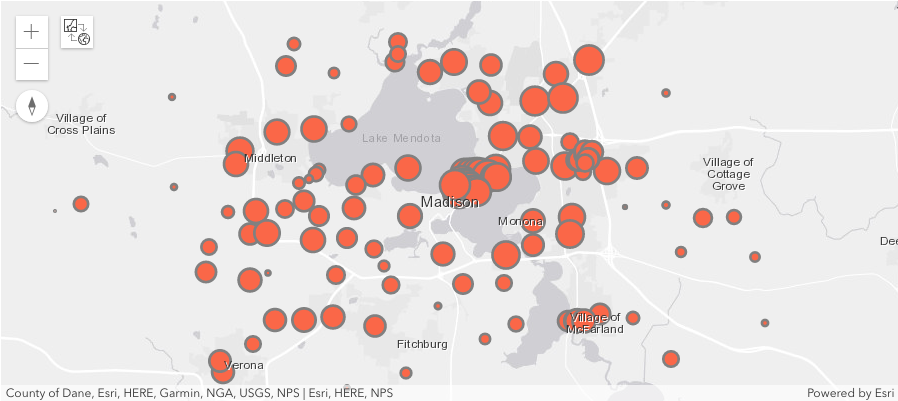

In [90]:
gis = GIS('home')
map1 = gis.map('Madison, Wisconsin')
map1.basemap = 'gray'
map1

While visualizing the location of the point observations, you can symbolize the points by their temperature. From the map above, we notice higher temperatures (larger symbols) clustered near the downtown area.

In [86]:
temperature_sdf.plot(kind='map', map_widget=map1,
                     colors='Reds_r', size_field=temperature_field)

True

### Histogram of temperature measurements
Next, create a histogram of the temperature measurements to visualize the distribution of the temperature measurements.

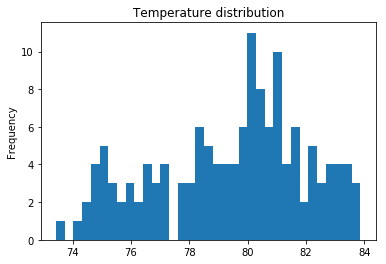

In [39]:
# Create histogram of temperature
temperature_hist = temperature_sdf[temperature_field].plot(kind='hist', 
                                                           title = 'Temperature distribution', bins=35)

The distribution is slightly negatively skewed, but there are no obvious outliers, and the most frequent temperatures were between approximately `80` and `82` degrees.

Before you perform a spatial interpolation of the temperature measurements, you need to verify that they are **spatially autocorrelated**, which is a requirement for every spatial interpolation method.  This means that points that are closer together must have more similar temperatures, on average, than points that are farther apart. To verify the presence of spatial autocorrelation, you will perform a **Moran's I** test for global autocorrelation. 

In [40]:
# Calculate Global Moran's I statistic and test for significance
arcpy.stats.SpatialAutocorrelation(temperature_fc, temperature_field)
messages = arcpy.GetMessage(3)
print(messages)


 Global Moran's I Summary
Moran's Index:   0.696963 
Expected Index:  -0.007246
Variance:        0.002148 
z-score:         15.193428
p-value:         0.000000 

Distance measured in Meters



The large `z-score` and very low `p-value` indicate that the temperature measurements do display spatial autocorrelation.  This should be unsurprising, and it justifies performing interpolation on the temperature measurements.

## Interpolate the temperature measurements using Empirical Bayesian Kriging

To interpolate the temperature in Madison, Wisconsin from the temperature measurements into a continuous temperature surface, you will use [Empirical Bayesian Kriging (EBK)](http://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/what-is-ebk-regression-prediction-.htm). EBK works by first subsetting the point measurements, then simulating different spatial models for each subset. These local models are then mixed together to produce the final interpolation result. 

Since there are `139` points, you will use a subset size of `50`. This will create three subsets that slightly overlap.  This will allow both local and stable estimations of the temperature.

The output of the interpolation will be a *geostatistical layer* that can easily be queried for model diagnostics and exported to convenient formats.

In [41]:
%%time
# Perform Empiricial Bayesian Kriging on the temperature measurements
temperature_ga_layer = "temperature_EBK"
subset_size = 50
arcpy.ga.EmpiricalBayesianKriging(in_features=temperature_fc, z_field=temperature_field, 
                                  out_ga_layer=temperature_ga_layer, max_local_points=subset_size)

CPU times: user 932 ms, sys: 976 ms, total: 1.91 s
Wall time: 1.28 s


### Cross-validation
To verify that your interpolation result is accurate and reliable, you will now investigate cross-validation statistics. Cross-validation is a `leave-one-out` validation method that sequentially hides each input point and uses all remaining points to predict back to the location of the hidden point. The measured value at the hidden point is then compared to the prediction value from cross-validation; the difference between these two values is called the cross-validation error for the point.

The logic of cross-validation is that if your interpolation model is accurate and reliable, the remaining points should be able to accurately predict the measured value of the hidden point. If the predictions from cross-validation are close to the measured temperature values, this gives you confidence that your model can accurately predict temperature values at new locations.

In [42]:
# Run cross validation on Empirical Bayesian Kriging results
cv = arcpy.ga.CrossValidation(in_geostat_layer=temperature_ga_layer, 
                              out_point_feature_class=os.path.join(out_gdb,'ga_cv_results'))

# Print the cross validation summary statistics
print("Mean = "+cv.meanError)
print("Root Mean Square = "+ cv.rootMeanSquare)
print("Average Standard = "+ cv.averageStandard)
print("Mean Standardized = "+ cv.meanStandardized)
print("Root Mean Square Standardized = "+ cv.rootMeanSquareStandardized)
print("Percent in 90% Interval = "+ cv.percentIn90Interval)
print("Percent in 95% Interval = "+ cv.percentIn95Interval)
print("Average CRPS = "+ cv.averageCRPS)

Mean = 0.127827402905702
Root Mean Square = 1.68371213658715
Average Standard = 1.67652534707903
Mean Standardized = 0.0355450093243331
Root Mean Square Standardized = 0.988525369213755
Percent in 90% Interval = 91.3669064748201
Percent in 95% Interval = 96.4028776978417
Average CRPS = 0.884121078260746


There are several important observations to make in these cross-validation summary statistics.
* The **Mean** and **Mean Standardized** cross-validation errors are both close to zero.  This indicates that the model has small levels of bias and does not have a tendency to make predictions that are systematically too high or low.
* The **Root Mean Square** statistic indicates that on average, the predicted temperatures differed from the measured temperatures by less than two degrees. This is an acceptable level of precision for 139 points. The root mean square is also very close to the **Average Standard** error, which indicates consistency between accuracy and uncertainty of the model.
* The **Root Mean Square Standardized** statistic is very close to one, which indicates that standard errors of the predicted values are not being systematically overestimated or underestimated.  
* The **Percent in 90/95% Interval** values are close to the ideal values of `90` and `95`. This indicates that the variability of the predicted values is being estimated correctly.
* The **Average CRPS** is difficult to interpret literally, but the value should be as small as possible.  This statistic will be compared to a different model later in this lesson.

These statistics do not provide any reason to doubt the accuracy of the interpolation results.  They indicate a **precision** of less than `2` degrees, and estimates of prediction uncertainty are accurate.

Next, you will make graphs showing various features of the cross-validation results.

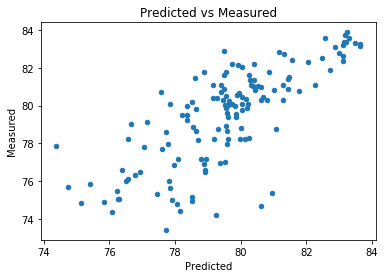

In [46]:
# Create spatial data frame of EBK cross validation results
cv_sdf = SpatialDataFrame.from_featureclass(os.path.join(out_gdb,'ga_cv_results'))

# Create scatterplot of predicted values versus measured values
cv_PvM_graph = cv_sdf[['Predicted', 'Measured']].plot(kind='scatter', x='Predicted', y='Measured', 
                                                      title='Predicted vs Measured')

The *Predicted vs Measured* scatter plot shows that the predicted values are approximately equal to the measured values for the entire temperature range.  There is significant variability of the points around the $y=x$ line, but the linear pattern is clear.  Since the measured values should be approximately equal to the predicted values, this linear pattern indicates that the model is working correctly.

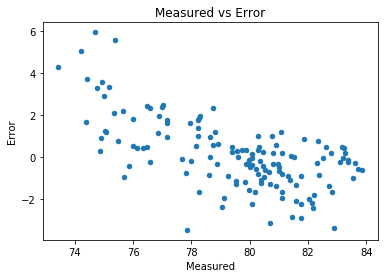

In [47]:
# Create scatterplot of measured values versus error values
cv_MvE_graph = cv_sdf[['Measured', 'Error']].plot(kind='scatter', x='Measured', y='Error',
                                                 title='Measured vs Error')

The *Measured vs Error* scatter plot shows a slight negative relationship between the measured value and the cross-validation error.  This downward trend indicates a small degree of **smoothing** in the model; high temperatures are being underestimated, and low temperatures are being overestimated.  Some degree of smoothing occurs in nearly every interpolation model, and this smoothing is not severe.

Text(0,0.5,'Standardized Error')

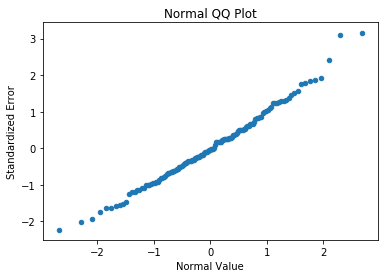

In [48]:
# Create Normal QQ plot of the standardized error values
cv_QQ_graph = cv_sdf[['NormValue', 'Stdd_Error']].plot(kind='scatter', x='NormValue', 
                                                       y='Stdd_Error', title = 'Normal QQ Plot')
cv_QQ_graph.set_xlabel('Normal Value')
cv_QQ_graph.set_ylabel('Standardized Error')

The *Normal QQ* plot of standardized errors shows an approximate linear pattern along the $y=x$ line, but there are some deviations on the tails of the distribution.  This indicates that the predicted values are approximately normally distributed for most of the distribution, but care should be taken when creating margins of error for temperatures on the extreme ends of the distribution.

## Incorporate impervious surfaces in order to improve the interpolation

You will now incorporate an explanatory variable into the interpolation using EBK Regression Prediction.

As the name implies, [EBK Regression Prediction](http://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/what-is-ebk-regression-prediction-.htm) is a regression-kriging method that is a hybrid of EBK and linear regression. EBK Regression Prediction allows you to use explanatory variable rasters that you know are related to the variable you are interpolating. The explanatory variables must be rasters so that every prediction location has a known value of the explanatory variable; this is required in order to make predictions at new locations.

For these temperature measurements, you will incorporate the locations of impervious surfaces into the interpolation. **Each cell in the raster represents the percent of that cell that is impervious to water**. 
Impervious surfaces are important contributors to urban heat islands because these surfaces (usually buildings and other manmade structures) trap the heat in the middle of dense cities and prevent it from diffusing into surrounding rural areas.

### Visualize the impervious raster surface

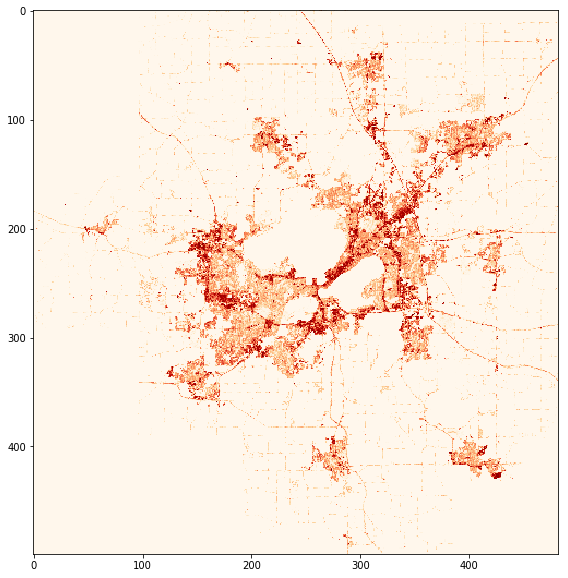

In [94]:
from arcpy import Raster
impervious_raster = Raster(imperv_raster)

display_array = arcpy.RasterToNumPyArray(impervious_raster)

figs, ax = plt.subplots(1,1, figsize=(20,10))
ax.imshow(display_array, cmap='OrRd')

### Verify that impervious surfaces are related to temperature
Before including impervious surfaces as an explanatory variable, you must first verify that it is linearly correlated with temperature.  To do this, you will first extract extract the cell values of the impervious surface raster to the temperature measurements, then make a scatter plot to visualize the relationship.

In [95]:
# Extract the impervious percent values to the temperature measurements
impervious_fc = os.path.join(out_gdb, "Impervious_Points")
arcpy.sa.ExtractValuesToPoints(temperature_fc, impervious_raster, impervious_fc)

<geoprocessing server result object at 0x7f36995fead0>

Text(0,0.5,'Temperature (F)')

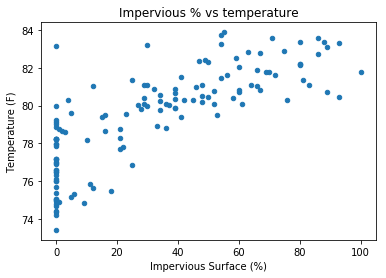

In [96]:
# read the impervious feature class into a DataFrame
impervious_sdf = SpatialDataFrame.from_featureclass(impervious_fc, sr = sr.as_arcpy)

# Create scatterplot of impervious surface percent and temperature
imperv_graph = impervious_sdf[['RASTERVALU', 'TemperatureF']].plot(kind='scatter',
                                                                   x='RASTERVALU', 
                                                                   y='TemperatureF', 
                                                                   title = 'Impervious % vs temperature')
imperv_graph.set_xlabel('Impervious Surface (%)')
imperv_graph.set_ylabel('Temperature (F)')

The scatter plot shows that the percent of impervious surface is positively correlated with temperature, and the relationship is approximately linear.  This justifies using impervious surface percent as an explanatory variable in EBK Regression Prediction.

You will now run EBK Regression Prediction using the same subset size of `50` that was used previously. You will use the impervious surface raster as an explanatory variable, and you will create a raster and geostatistical layer predicting the temperature within the block groups of Madison, Wisconsin.  

## Perform EBK Regression Prediction on the temperature measurements using impervious area as an explanatory variable

In [98]:
%%time
# Create variables for output raster and output geostatistical layer
ebk_reg_pred_rast = os.path.join(out_gdb,'temperature_prediction')
ebk_reg_pred_ga_layer = 'temperature_ga_layer'

# Set the subset size to 50 and the extent to the block groups
subset_size = 50
arcpy.env.extent = block_group_fc

# Set the explanatory variable raster
expl_var = imperv_raster

# Run EBKRP
arcpy.ga.EBKRegressionPrediction(in_features=temperature_fc, 
                                 dependent_field=temperature_field, 
                                 in_explanatory_rasters=expl_var, 
                                 out_ga_layer=ebk_reg_pred_ga_layer, 
                                 out_raster=ebk_reg_pred_rast,
                                 max_local_points = subset_size)

# Revert extent to default
arcpy.env.extent = ''

CPU times: user 12min 43s, sys: 0 ns, total: 12min 43s
Wall time: 44.4 s


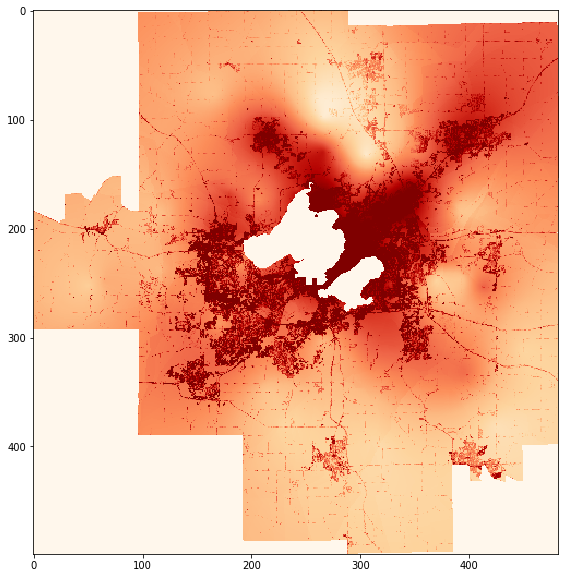

In [111]:
ebk_reg_pred_raster_obj = Raster(os.path.join(out_gdb,'temperature_prediction'))

display_array = arcpy.RasterToNumPyArray(ebk_reg_pred_raster_obj)

figs, ax = plt.subplots(1,1, figsize=(20,10))
ax.imshow(display_array, cmap='OrRd', vmax=80, vmin=74)

### Cross-validation
To determine if including the explanatory variable improved the predicted temperatures, you will now investigate the cross-validation results and compare them to the result from Empirical Bayesian Kriging.

In [112]:
# Run cross validation on EBKRP results
cv2 = arcpy.ga.CrossValidation(in_geostat_layer=ebk_reg_pred_ga_layer, 
                               out_point_feature_class=os.path.join(out_gdb,'cv2_results'))

# Print the cross validation summary statistics
print("Mean Error = "+cv2.meanError)
print("Root Mean Square = "+ cv2.rootMeanSquare)
print("Average Standard = "+ cv2.averageStandard)
print("Mean Standardized = "+ cv2.meanStandardized)
print("Root Mean Square Standardized = "+ cv2.rootMeanSquareStandardized)
print("Percent in 90% Interval = "+ cv2.percentIn90Interval)
print("Percent in 95% Interval = "+ cv2.percentIn95Interval)
print("Average CRPS = "+ cv2.averageCRPS)

Mean Error = 0.0836083232796646
Root Mean Square = 1.28470978121929
Average Standard = 1.37953223053424
Mean Standardized = 0.0393003852420266
Root Mean Square Standardized = 0.918408992428606
Percent in 90% Interval = 91.2408759124088
Percent in 95% Interval = 95.6204379562044
Average CRPS = 0.701214788259404


These results display many of the same features as the results from Empirical Bayesian Kriging, but there are several important things to note:
* The **Mean** and **Mean Standardized** are again both close to zero and do not display any significant bias.
* The **Root Mean Square** statistic is approximately 25% lower than the previous model and is again approximately equal to the **Average Standard** error.  This indicates that the new model has smaller average errors.
* The **Root Mean Square Standardized** statistic again very close to one, which indicates that standard errors are being estimated accurately.  
* The **Percent in 90/95% Interval** values are again close to the idea values of 90 and 95. 
* The **Average CRPS** is approximately 20% lower than the previous model.  This is more strong evidence that this model is more accurate and precise.

These statistics give very strong evidence that including the locations of impervious surfaces significantly improved the accuracy and precision of the predicted temperatures.

Next, you will create graphs of the cross-validation results.

### Model evaluation charts

In [114]:
# read the cross validation results into a DataFrame
cv2_sdf = SpatialDataFrame.from_featureclass(os.path.join(out_gdb,'cv2_results'))
cv2_sdf.head()

,OBJECTID,Measured,Predicted,Error,StdError,Stdd_Error,NormValue,CRPS,QuanVal,Interval90,Interval95,Source_ID,Included,SHAPE
0,1,75.681,76.071604,0.390604,2.259891,0.172842,0.183999,0.543666,0.425756,Yes,Yes,1,Yes,"{'x': 568498.1158999996, 'y': 311161.271999999..."
1,2,78.208,78.308060,0.100060,1.970316,0.050784,0.018298,0.447814,0.480574,Yes,Yes,2,Yes,"{'x': 585794.6459999997, 'y': 306036.104800000..."
2,3,74.856,75.551294,0.695294,1.478514,0.470265,0.537039,0.465019,0.317563,Yes,Yes,3,Yes,"{'x': 568879.6446000002, 'y': 305553.072100000..."
3,4,75.985,77.391623,1.406623,2.146669,0.655258,0.623666,0.850851,0.253733,Yes,Yes,4,Yes,"{'x': 559305.5541000003, 'y': 305966.713300000..."
4,5,74.381,76.052707,1.671707,1.385723,1.206379,1.210004,1.052453,0.112422,Yes,Yes,5,Yes,"{'x': 569435.3502000002, 'y': 303945.071599999..."


Below, we combine all 4 model evaluation charts into one plot with many sub-plots.

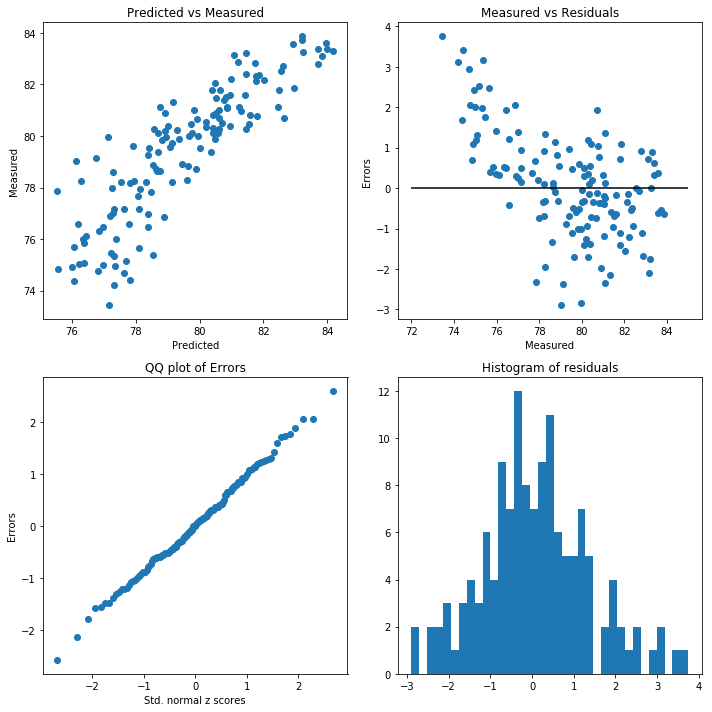

In [123]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
# plt.tight_layout()

plt1 = axs[0][0].scatter(x=cv2_sdf['Predicted'], y=cv2_sdf['Measured'])
axs[0][0].set_title('Predicted vs Measured')
axs[0][0].set_xlabel('Predicted')
axs[0][0].set_ylabel('Measured')

plt2 = axs[0][1].scatter(x=cv2_sdf['Measured'], y=cv2_sdf['Error'])
axs[0][1].hlines(0, xmin=72, xmax=85)
axs[0][1].set_title('Measured vs Residuals')
axs[0][1].set_xlabel('Measured')
axs[0][1].set_ylabel('Errors')

axs[1][0].scatter(x=cv2_sdf['NormValue'], 
                  y=cv2_sdf['Stdd_Error'])
axs[1][0].set_title('QQ plot of Errors')
axs[1][0].set_xlabel('Std. normal z scores')
axs[1][0].set_ylabel('Errors')

axs[1][1].hist(cv2_sdf['Error'], bins=35)
axs[1][1].set_title('Histogram of residuals')
plt.tight_layout()

From the model evaluation charts above, we notice:
 - The **Predicted vs Measured** scatter plot again shows a linear relationship between the measured values and the predicted values along the $y=x$ line.
 - The negative trend in the **Measured vs Residuals** scatter plot again indicates that there is some degree of smoothing, but the smoothing is not severe.
 - The **QQ plot of standardized errors** shows that the standard errors appear to follow a normal distribution for all values of the temperature, even at the extremes of the distribution. This is very useful to know because it allows you to more accurately model extreme heat events.
 - The **Histogram of residuals** plot shows a good bell-shaped curve, resembling a normal distribution.

Taken together, these cross-validation summary statistics and graphs give very strong evidence that including the locations of impervious surfaces into the interpolation improves the accuracy of the interpolation.

## Locate block groups with high risk of heat illnesses

Now that you have a reliable map predicting temperature across Madison, Wisconsin, you will now calculate the average temperature within each block group of the city.  You will then determine if there any block groups that had high average temperatures and a high density of residents over the age of 65. These residents are at highest risk for heat-related illnesses, so mitigation efforts can be focused on these block groups.

You will now use **Zonal Statistics** to calculate the average of the temperature prediction raster within each block group.  This table will then be joined to the block groups so that they can be analyzed.

In [124]:
# Create a layer of the block groups so that it can later be joined
block_group_lyr = 'block_groups_layer'
arcpy.management.MakeFeatureLayer(in_features=block_group_fc, out_layer=block_group_lyr)

<Result 'block_groups_layer'>

Preview the block groups layer:

In [146]:
block_group_sdf = SpatialDataFrame.from_featureclass(block_group_fc, sr = sr.as_arcpy)
block_group_sdf.head()

,OBJECTID,Block_Groups_TOTPOP10,Block_Groups_PopOver65,Block_Groups_Over65Density,SHAPE
0,1,2058,119,57823.129252,"{'rings': [[[-89.22584195622859, 43.1934261905..."
1,2,2466,239,96918.085969,"{'rings': [[[-89.37970538381867, 42.9221040499..."
2,3,2771,178,64236.737640,"{'rings': [[[-89.42359704393006, 43.0264507692..."
3,4,1529,191,124918.247220,"{'rings': [[[-89.32354269404401, 43.2236626317..."
4,5,2903,230,79228.384430,"{'rings': [[[-89.32354269404401, 43.2236626317..."


Let us visualize the block groups layer on a map. We will symbolize this map by population over the age `65`.


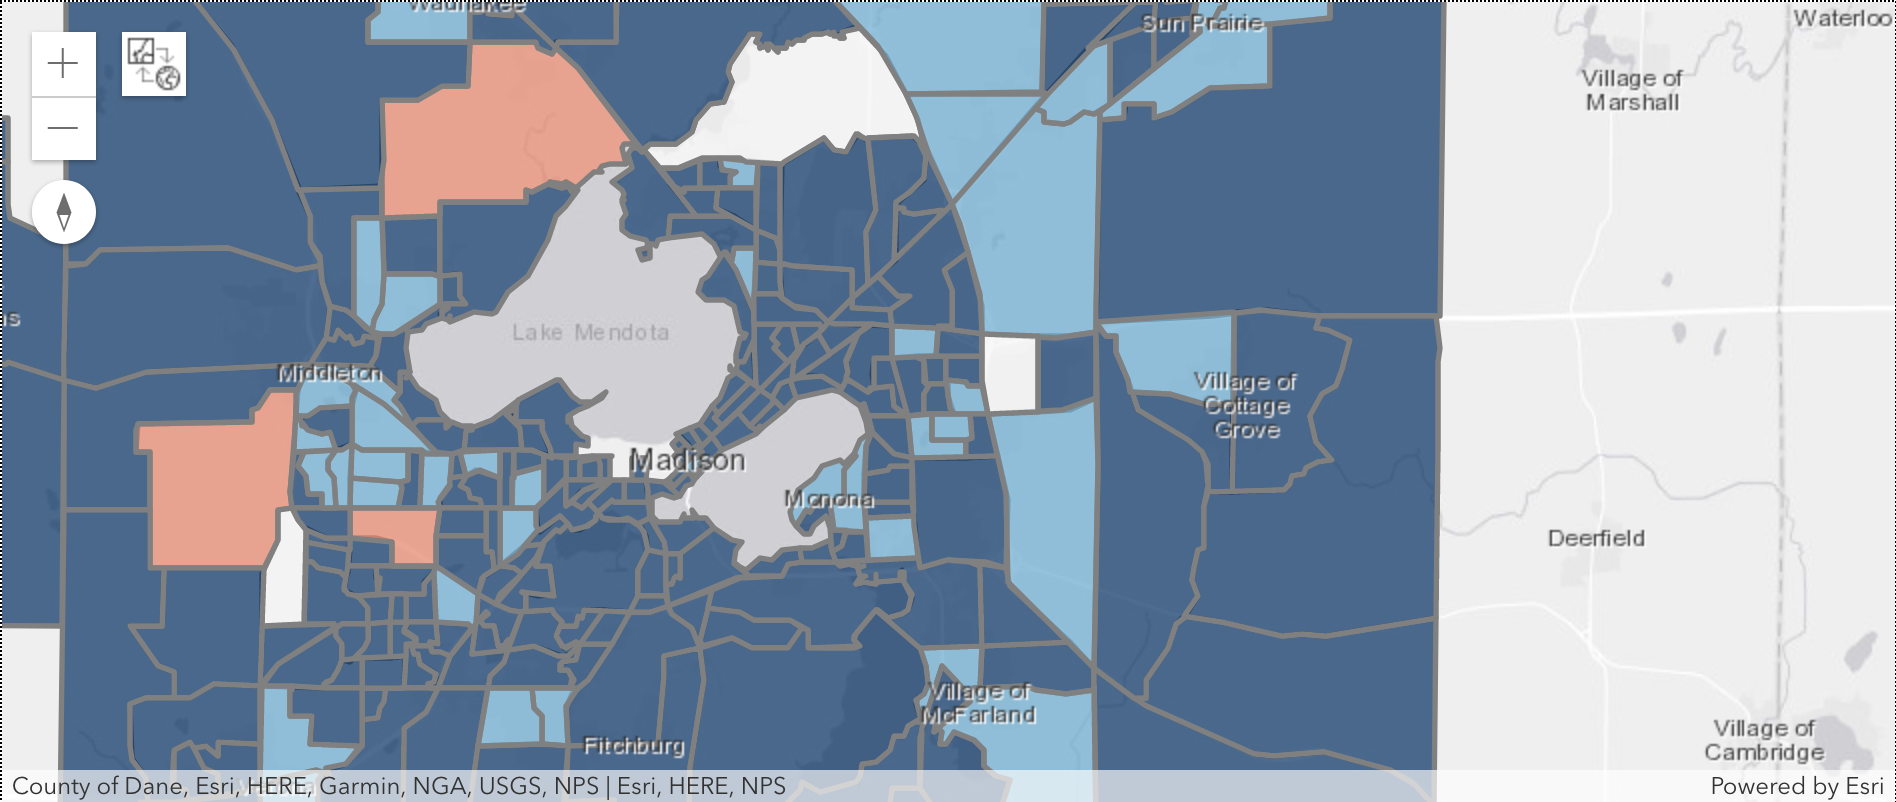

In [152]:
block_groups_map = gis.map('Madison, Wisconsin')
block_groups_map.basemap='gray'
block_groups_map

In [151]:
block_group_sdf.plot(kind='map', map_widget=block_groups_map, 
                     renderer_type='c',  # for class breaks renderer
                     method='esriClassifyNaturalBreaks',  # classification algorithm
                     class_count=5,  # choose the number of classes
                     col='Block_Groups_PopOver65',  # numeric column to classify
                    cmap='RdBu_r',  # color map to pick colors from for each class
                    alpha=0.7  # specify opacity
                    )

True

In the map above, the block groups in *red* indicate higher number of people over `65`.

In [126]:
# Calculate the average temperature in each block group by using Zonal Statistics
# as Table and attaching the table to the block group layer
temperature_table = os.path.join(out_gdb,'temperature_zonal')
arcpy.sa.ZonalStatisticsAsTable(in_zone_data = block_group_fc, zone_field = "OBJECTID", 
                                in_value_raster = ebk_reg_pred_raster_obj, 
                                out_table = temperature_table, 
                                ignore_nodata="DATA", 
                                statistics_type="MEAN")

<geoprocessing server result object at 0x7f366c61fda0>

Read the temperature table and display the first few records showing the mean temperature for each block group.

In [128]:
temperature_table_sdf = pd.DataFrame.spatial.from_table(temperature_table)
temperature_table_sdf.head()

,OBJECTID,OBJECTID_1,COUNT,AREA,MEAN
0,1,1,181,1810000.0,79.415725
1,2,2,341,3410000.0,76.338762
2,3,3,216,2160000.0,78.901788
3,4,4,1252,12520000.0,76.476324
4,5,5,367,3670000.0,76.212982


Now we can join the temperature table back to the block groups layer for further analysis.

In [132]:
# Now join the block group layer with the temperature table
arcpy.management.AddJoin(in_layer_or_view=block_group_lyr, in_field="OBJECTID", 
                         join_table= temperature_table, join_field="OBJECTID", 
                         join_type="KEEP_ALL")

<Result 'block_groups_layer'>

Create a scatter plot of average temperature versus density of residents over the age of `65` in order to see any block groups with both high temperature and high elderly density.

In [136]:
block_group_sdf = SpatialDataFrame.from_featureclass(block_group_lyr)
block_group_sdf.head()

,Block_Groups.OBJECTID,Block_Groups.Block_Groups_TOTPOP10,Block_Groups.Block_Groups_PopOver65,Block_Groups.Block_Groups_Over65Density,temperature_zonal.OBJECTID,temperature_zonal.OBJECTID_1,temperature_zonal.COUNT,temperature_zonal.AREA,temperature_zonal.MEAN,SHAPE
0,1,2058,119,57823.129252,1,1,181,1810000.0,79.415725,"{'rings': [[[582902.1760999998, 302585.6850000..."
1,2,2466,239,96918.085969,2,2,341,3410000.0,76.338762,"{'rings': [[[570623.0864000004, 272351.2597000..."
2,3,2771,178,64236.737640,3,3,216,2160000.0,78.901788,"{'rings': [[[566961.5527999997, 283913.2996999..."
3,4,1529,191,124918.247220,4,4,1252,12520000.0,76.476324,"{'rings': [[[574936.5900999997, 305874.7409000..."
4,5,2903,230,79228.384430,5,5,367,3670000.0,76.212982,"{'rings': [[[574936.5900999997, 305874.7409000..."


Text(0,0.5,'Density Over 65')

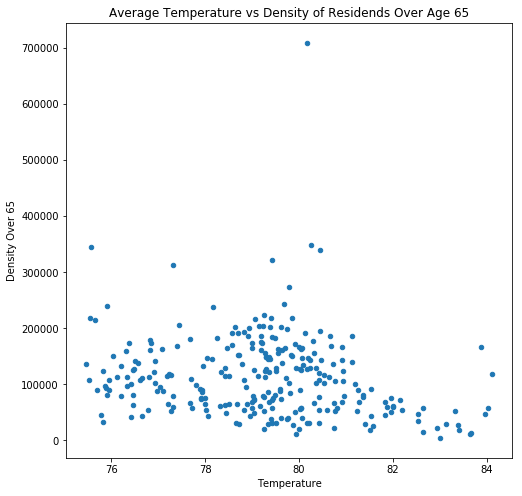

In [139]:
# Create a scatterplot of average temperature versus density of residents over age 65 in each block group
density_scatter = block_group_sdf.plot(kind='scatter', x='temperature_zonal.MEAN', 
                                       y='Block_Groups.Block_Groups_Over65Density',
                                       title = 'Average Temperature vs Density of Residends Over Age 65',
                                      figsize=(8,8))

density_scatter.set_xlabel('Temperature')
density_scatter.set_ylabel('Density Over 65')

Fortunately, there appears to be little correlation between temperature and density of at-risk residents. There is, however, one block group with a very high density of elderly residents. This block group should be closely monitored during future extreme heat events.

## Conclusion

In this lesson, you built an interpolation workflow for modeling the urban heat island effect in Madison, Wisconsin.  You first used Empirical Bayesian Kriging to interpolate 139 temperature measurements taken on August 8, 2016 at 8:00PM.  You validated the model using summary statistics and graphical diagnostics.  You then improved the interpolation model by incorporating the locations of impervious surfaces using EBK Regression Prediction.  Finally, you compared the average temperature and the density of residents over the age of 65 in the block groups of Madison.  You determined that on this date, there were no block groups with high temperatures and high density of at-risk residents.

The urban heat island effect is present in virtually every major city in the world, and the workflow you developed in these lessons can be used to analyze other cities and other dates.  You are encouraged to repeat this exercise in different cities and on different days.  Many potential explanatory variables could prove useful in analyzing urban heat, and you should use the skills you developed in this lesson to develop your own models.